## Desafio Analytics

O objetivo do case é prever a movimentação das catracas do metrô de Nova York.
Temos a disposição base de dados da movimentação (fluxo acumulado de entrada e saída) das catracas de metrô para cada estação, linha, tempo de ocorrência.

Nesse notebook, verificarei os dados disponíveis e preparar os dados para realizar análises estatísticas e modelagem nos notebooks posteriores.

In [1]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import SequenceMatcher
from copy import deepcopy
%matplotlib inline
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/Raizen/'

## Teste de sanidade
Antes de iniciar as análises, irei checar a volumetria dos dados para cada ano mês para checar a consistência da base.

In [0]:
df = pd.concat([pd.read_csv(f"{path}{ano}.csv.gz", usecols=['time'], parse_dates=['time']) for ano in range(2010, 2018)])

In [0]:
df_year_month = df['time'].dt.to_period('M').value_counts().sort_index()

<------2010------>


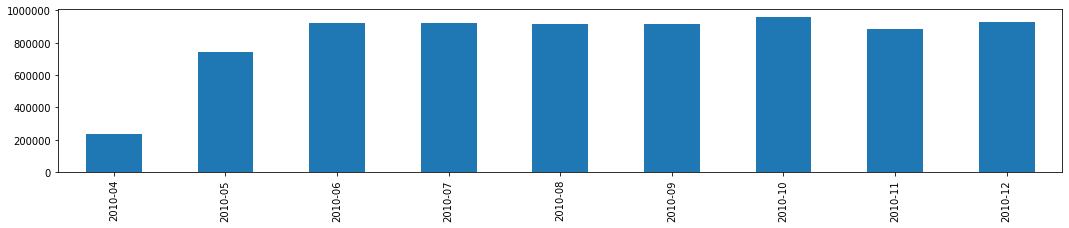

<------2011------>


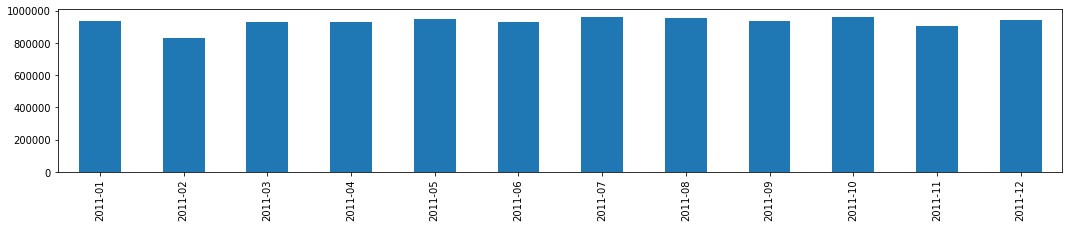

<------2012------>


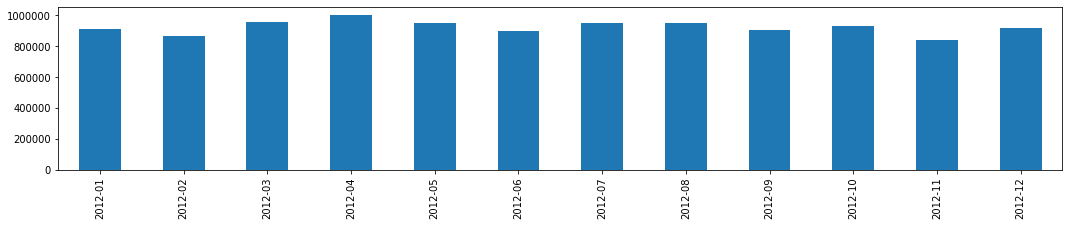

<------2013------>


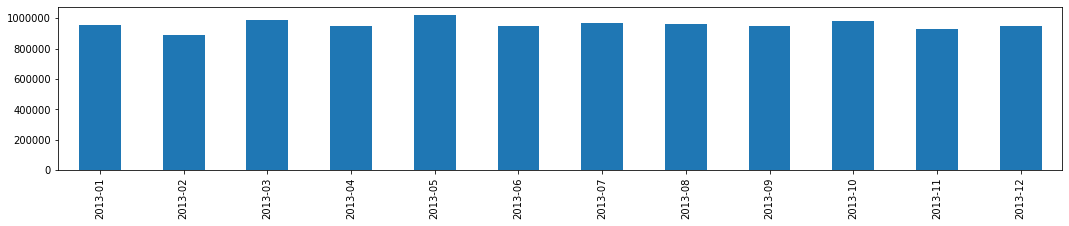

<------2014------>


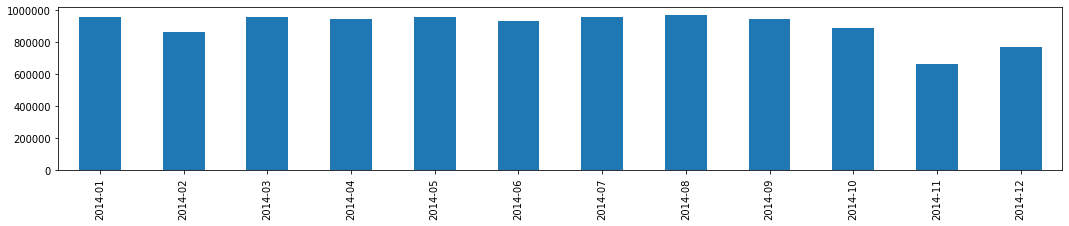

<------2015------>


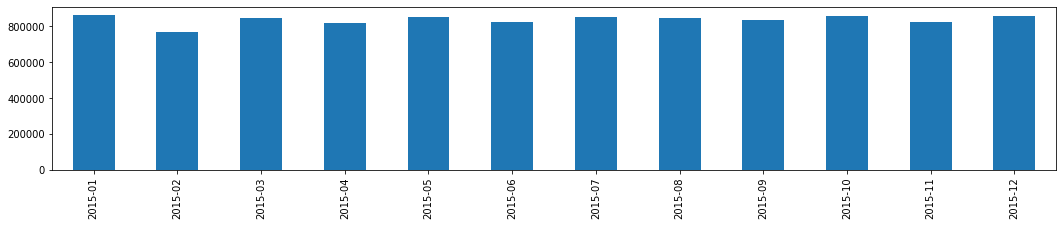

<------2016------>


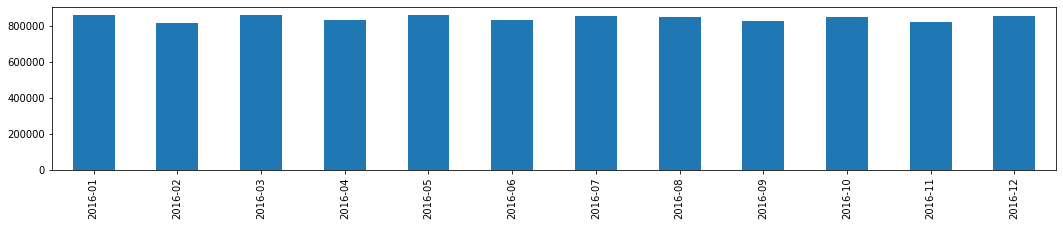

<------2017------>


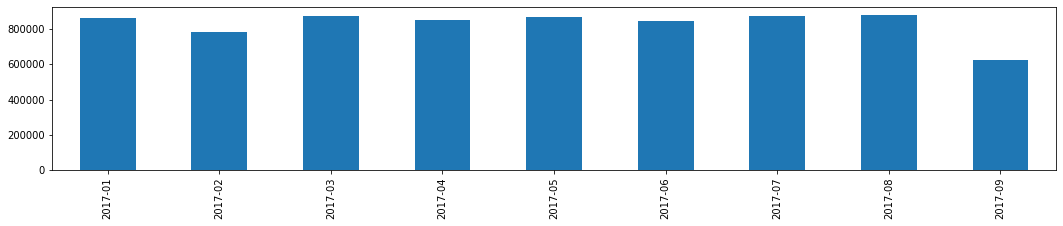

In [0]:
for year in range(2010, 2018):
    df_year = df_year_month[df_year_month.index.year == year]
    print(f'<------{year}------>')
    df_year.plot(kind='bar', figsize=(18, 3))
    plt.show()

Podemos ver que não temos dados anteriores a 04/2010 e depois de 09/2017
Além disso, aparentemente a volumetria desses meses está menor que em meses similares de outros anos.

Investigarei melhor essas volumetrias para cada ano mês

In [0]:
df_year_month_frame = df_year_month.to_frame()
df_year_month_frame['year'] = df_year_month_frame.index.year
df_year_month_frame['month'] = df_year_month_frame.index.month
df_year_month_frame.reset_index(inplace=True)

In [0]:
pd.pivot(df_year_month_frame, index='month', columns='year', values='time')

year,2010,2011,2012,2013,2014,2015,2016,2017
month,,,,,,,,
1,NaN,932427.0,912896.0,953517.0,958650.0,865561.0,861742.0,860221.0
2,NaN,827511.0,863919.0,892061.0,862425.0,768919.0,817131.0,785110.0
3,NaN,931305.0,954575.0,988158.0,959007.0,849451.0,862350.0,872898.0
4,237015.0,926277.0,1004669.0,951634.0,943245.0,822170.0,830484.0,850870.0
5,740309.0,945542.0,949446.0,1023177.0,960230.0,850325.0,860978.0,868706.0
6,921108.0,926306.0,899683.0,949509.0,930798.0,823706.0,832063.0,845608.0
7,923053.0,961642.0,948078.0,970908.0,958179.0,850344.0,853847.0,874964.0
8,913255.0,951212.0,950077.0,959727.0,971095.0,850012.0,851827.0,880515.0
9,915056.0,936834.0,904349.0,949087.0,946343.0,833702.0,829751.0,627133.0


A tabela informa que as volumetrias de 04/2010, 05/2010 e 09/2017 estão menores que em mesmos meses de outros anos.

Também podemos visualizar as mesmas informações pelos boxplots abaixos.

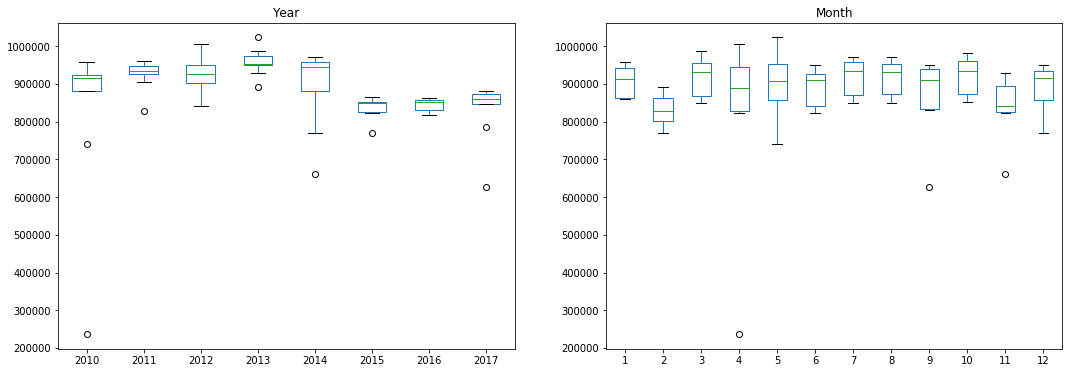

In [0]:
fig, ax = plt.subplots(1, 2,  figsize=(18, 6))

pd.pivot(df_year_month_frame, index='month', columns='year', values='time').plot(kind='box', ax=ax[0], title='Year')
pd.pivot(df_year_month_frame, index='year', columns='month', values='time').plot(kind='box', ax=ax[1], title='Month')
plt.show()

Dessa forma, não usarei os dados dos anos de 2010 e 2017, visto que não temos informações completas de todos os meses.

## Dataprep


In [0]:
df = pd.concat([pd.read_csv(f"{path}{ano}.csv.gz", parse_dates=['time']) for ano in range(2011, 2017)])

In [28]:
len(df)

64722782

Irei utilizar somente dados da coluna `desc = REGULAR`, que de acordo com os metadados, representam coleta de fluxo acumulado de regular (intervalo de 4h). Os dados com esse filtro representam `90,5%` do dataset.

In [29]:
df['desc'].value_counts(normalize=True).round(3)

REGULAR       0.905
RECOVR AUD    0.020
DOOR OPEN     0.018
DOOR          0.009
DOOR CLOSE    0.008
RECOVR        0.008
OPEN          0.008
AUD           0.008
LOGON         0.005
LGF-MAN       0.003
TS            0.002
VLT           0.002
TS VLT OPN    0.002
OPN           0.002
BRD           0.000
CHG           0.000
TS BRD CHG    0.000
LGF-SHUTDN    0.000
B5B6B7B8B9    0.000
069           0.000
REGUL         0.000
9798999A9B    0.000
101           0.000
064           0.000
037           0.000
Name: desc, dtype: float64

In [0]:
# filtering only desc REGULAR
df = df.query('desc == "REGULAR"').drop('desc', axis=1)

# converting entries and exits to integers
df[['entries', 'exits']] = df[['entries', 'exits']].astype('int')

Apesar de usar somente os dados `REGULAR`, checarei se os horários de coleta de dados das catracas realmente são de intervalos de 4h.

In [0]:
df['time'].dt.time.nunique()

86400

Pelo visto, os dados foram coletados em diferentes horários além dos intervalos de 4h.
Vou observar a volumetria de cada horário de coleta.

In [31]:
df['time'].dt.time.value_counts(normalize=True).round(5).head(30)

08:00:00    0.08697
04:00:00    0.08658
00:00:00    0.08620
16:00:00    0.08612
20:00:00    0.08595
12:00:00    0.08207
09:00:00    0.06137
05:00:00    0.06103
01:00:00    0.06094
17:00:00    0.06080
21:00:00    0.06074
13:00:00    0.05862
06:00:00    0.00420
14:00:00    0.00403
02:00:00    0.00403
10:00:00    0.00402
22:00:00    0.00402
18:00:00    0.00402
03:00:00    0.00180
07:00:00    0.00180
11:00:00    0.00179
19:00:00    0.00179
23:00:00    0.00179
15:00:00    0.00179
04:22:00    0.00136
12:22:00    0.00136
08:22:00    0.00136
16:22:00    0.00136
00:22:00    0.00136
20:22:00    0.00136
Name: time, dtype: float64

Os horários de intervalos de 4h iniciando em 0h (`00:00:00`, `04:00:00`, `08:00:00`, `12:00:00`, `16:00:00` e `20:00:00`) representam 51% dos dados. 

No entanto, irei considerar todos os dados que tem coletas realizadas em horas cheias (`00:00:00`, `01:00:00`, `02:00:00`, ..., `23:00:00`) que representam 91% dos dados.

In [0]:
df = df[(df['time'].dt.minute == 0)&(df['time'].dt.second == 0)]

Agora com o dataset filtrado, checarei se a defasagem dos horários de coleta ocorreu em algum período específico ou se é uniforme para todos os anos e meses.

In [0]:
df_hora = df['time'].to_frame()
df_hora['year_month'] = df_hora['time'].dt.to_period('M')
df_hora['time'] = df_hora['time'].dt.hour
df_hora['count'] = 1

In [0]:
def draw_heatmap(df, row, col, value, annot=False):
    df_group = df.groupby([row, col])[value].sum().reset_index()
    df_group = df_group.set_index([row, col])[value].unstack(0)
    
    plt.figure(figsize=(16,10))
    sns.heatmap(df_group, vmin=-1, cmap='YlGnBu', annot=annot, linewidths=.5)
    plt.show()

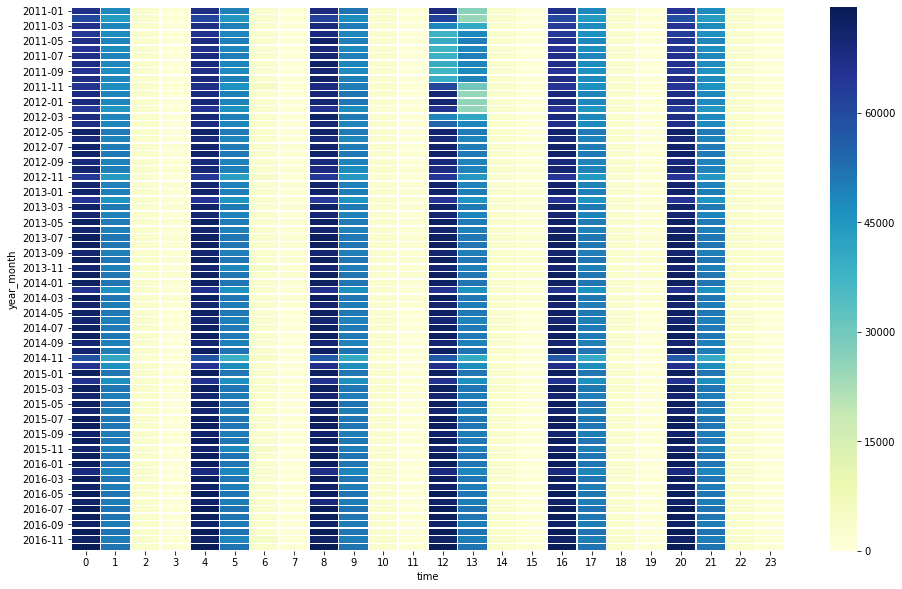

In [0]:
draw_heatmap(df_hora, row='time', col='year_month', value='count')

Aparentemente, os horários de coleta com defasagem permaneceram estáveis ao longo dos meses.
Uma análise mais aprofundada poderia ser feita avaliando se somente algumas estações, linhas ou catracas fizeram a coleta em horários defasados.

Agora avaliarei se o nome das estações possam estar com erros de digitação. Para isso, checarei se há similaridade entre nomes das estações.

In [0]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def find_similar(df):
    df_work = df[df['station'].str.contains('-') & df['station'].str.contains('ST')]
    stations = df_work.station.unique()
    similar_pairs = []
    for i,s in enumerate(stations):
        for j in range(i,len(stations)):
            if not i == j:
                sim = similar(sorted(s), sorted(stations[j]))
                if sim > 0.9:
                    similar_pairs.append((stations[i],stations[j]))
    print(similar_pairs)    

In [0]:
find_similar(df)

[('57 ST-7 AVE', '7 AVE-53 ST'), ('57 ST-7 AVE', '57 ST-7 AV'), ('42 ST-TIMES SQ', 'TIMES SQ-42 ST'), ('23 ST-5 AVE', '23 ST-6 AVE'), ('23 ST-5 AVE', '7 AVE-53 ST'), ('23 ST-5 AVE', '5 AVE-53 ST'), ('174-175 ST', '174-175 STS'), ('182-183 ST', '182-183 STS'), ('23 ST-6 AVE', '86 ST-2 AVE'), ('23 ST-6 AVE', '96 ST-2 AVE'), ('42 ST-GRD CNTRL', 'GRD CNTRL-42 ST'), ('149 ST-3 AVE', '3 AV-149 ST'), ('CATHEDRL-110 ST', '110 ST-CATHEDRL'), ('7 AVE-53 ST', '5 AVE-53 ST'), ('68ST-HUNTER COL', '68ST-HUNTER CO'), ('5 AVE-59 ST', '5 AVE-53 ST'), ('4AV-9 ST', '4 AV-9 ST'), ('86 ST-2 AVE', '96 ST-2 AVE')]


Acima evidenciamos que realmente existem estações com erros de digitação.
Olhando alguns casos, percebi que há muitas avenidas escritas de formas diferentes (`AVE`, `AV`, `AVENUE`) ou caractéres que podem ser eliminados (como `-` e `/` em `WAKEFIELD-241` e `WAKEFIELD/241`).

In [0]:
sorted(df['station'].astype(str).unique())

['1 AV',
 '1 AVE',
 '103 ST',
 '103 ST-CORONA',
 '104 ST',
 '110 ST',
 '110 ST-CATHEDRL',
 '110 ST-CPN',
 '111 ST',
 '116 ST',
 '116 ST-COLUMBIA',
 '121 ST',
 '125 ST',
 '135 ST',
 '137 ST CITY COL',
 '137 ST-CITY COL',
 '138 ST-3 AVE',
 '138 ST-GR CONC',
 '138/GRAND CONC',
 '14 ST',
 '14 ST-6 AVE',
 '14 ST-UNION SQ',
 '145 ST',
 '148 ST-LENOX',
 '149 ST-3 AVE',
 '149 ST-GR CONC',
 '149/GRAND CONC',
 '14TH STREET',
 '155 ST',
 '157 ST',
 '163 ST-AMSTERDM',
 '167 ST',
 '168 ST',
 '168 ST-BROADWAY',
 '169 ST',
 '170 ST',
 '174 ST',
 '174-175 ST',
 '174-175 STS',
 '175 ST',
 '176 ST',
 '18 AV',
 '18 AVE',
 '18 ST',
 '181 ST',
 '182-183 ST',
 '182-183 STS',
 '183 ST',
 '190 ST',
 '191 ST',
 '2 AV',
 '2 AVE',
 '20 AV',
 '20 AVE',
 '207 ST',
 '21 ST',
 '21 ST-QNSBRIDGE',
 '215 ST',
 '219 ST',
 '22 AVE-BAY PKY',
 '225 ST',
 '23 ST',
 '23 ST-5 AVE',
 '23 ST-6 AVE',
 '231 ST',
 '233 ST',
 '238 ST',
 '242 ST',
 '25 AV',
 '25 AVE',
 '25 ST',
 '28 ST',
 '28 ST-BROADWAY',
 '3 AV',
 '3 AV 138 ST',
 

In [0]:
def norm_names(x):
    replaces = {'57 ST-7 AV':'57 ST-7 AVE',
                'TIMES SQ-42 ST':'42 ST-TIMES SQ',
                '174-175 STS': '174-175 ST',
                '182-183 STS': '182-183 ST',
                '4AV-9 ST':'4 AV-9 ST',
                '110 ST-CATHEDRL':'CATHEDRL-110 ST',
                '68ST-HUNTER CO':'68ST-HUNTER COL',
                '149 ST-3 AVE':'3 AV-149 ST',
                '14TH STREET': '14 ST',
                '138 ST GR CONC': '138 GRAND CONC',
                'ASTOR PL': 'ASTOR PLACE',
                'KINGS HIGHWAY': 'KINGS HWY',
                'ROOSEVELT IS':'ROOSEVELT ISLND'
               }
    if x in replaces:
        return replaces[x]
    else:
        return x

df['station'] = df['station'].apply(lambda x: norm_names(x))        

In [0]:
df['station'] = df['station'].replace(to_replace=' AVE', value=' AV', regex=True)
df['station'] = df['station'].replace(to_replace='STS', value='ST', regex=True)
df['station'] = df['station'].replace(to_replace=' RD', value=' ROAD', regex=True)
df['station'] = df['station'].replace(to_replace='PKWY', value='PARKWAY', regex=True)
df['station'] = df['station'].replace(to_replace='-', value=' ', regex=True)
df['station'] = df['station'].replace(to_replace='/', value=' ', regex=True)

Agora que os nomes das estações estão padronizados, irei agrupar as colunas por `ca`, `unit`, `scp`, `station`, `linename` e `division`; e criarei a coluna `group_id` para cada combinação.

In [0]:
def groups_dict(groups):
    group_dict = defaultdict(int)
    for i in enumerate(list(groups)):
        group_dict[i[1]]= i[0]
    return group_dict

def groups_id(df):
    group = ['time', 'ca', 'unit', 'scp', 'station', 'linename', 'division']
    
    df = df.groupby(group, as_index=False).mean().round(0)

    df['group'] = df['ca'] + df['unit'] + df['scp'] + \
                  df['station'] + df['linename'] + df['division']    

    groups = set(df['group'])
    group_id_dict = groups_dict(groups)
    
    df['group_id'] = [group_id_dict[x] for x in df['group']]
    df = df.drop('group', axis=1)

    return df    

In [0]:
df = groups_id(df)

Para obter a contagem de pessoas que passaram por cada `group_id`, tirarei a diferença de valores acumulados `entries` e `exits` da linha atual com a linha anterior.

Porém, antes disso verificarei se há valores negativos em `entries` e `exits`.

In [37]:
df.query('entries < 0').head()

,time,ca,unit,scp,station,linename,division,entries,exits,group_id
17351299,2013-01-19 17:00:00,N182,R414,00-03-01,HOWARD BCH JFK,A,IND,-678035456.0,-644481024.0,5819
17355353,2013-01-19 21:00:00,N182,R414,00-03-01,HOWARD BCH JFK,A,IND,-678035072.0,-644480832.0,5819
17359395,2013-01-20 01:00:00,N182,R414,00-03-01,HOWARD BCH JFK,A,IND,-678034752.0,-644480640.0,5819
17363416,2013-01-20 05:00:00,N182,R414,00-03-01,HOWARD BCH JFK,A,IND,-678034560.0,-644480448.0,5819
17367459,2013-01-20 09:00:00,N182,R414,00-03-01,HOWARD BCH JFK,A,IND,-678034496.0,-644480384.0,5819


Realmente existem valores negativos, mas apesar disso, os valores estão aumentando. Então, aparentemente, podemos prosseguir para obtenção dos números de contagem baseado na diferença dos valores acumulados.

In [0]:
def diff_prev_row(df):
    # sorting
    df.sort_values(['group_id', 'time'], inplace=True)

    # identify first row
    df['first_row'] = df['group_id'] - df['group_id'].shift(1)
    df['first_row'] = df['first_row'].fillna(1)
    
    # diff entries and exit
    df['entries_diff'] = df['entries'] - df['entries'].shift(1, fill_value=0)
    df['exits_diff'] = df['exits'] - df['exits'].shift(1, fill_value=0)
    
    # diff time
    df['time_diff'] = df['time'] - df['time'].shift(1, fill_value=0)
    
    # drop first row
    df = df.query('first_row == 0')
    df = df.drop('first_row', axis=1)
    df.reset_index(drop=True, inplace=True)    
    return df

In [39]:
df.shape

(52992395, 10)

In [0]:
df = diff_prev_row(df)

Verificarei a volumetria da diferença entre defasagem de tempo.

In [41]:
df['time_diff'].value_counts(normalize=True).round(3).head()

04:00:00    0.970
01:00:00    0.015
08:00:00    0.011
12:00:00    0.002
16:00:00    0.001
Name: time_diff, dtype: float64

Os valores obtidos pela diferença de 4h representam 97% do dataset e usarei somente esses dados para fazer a análise.

In [0]:
df = df[df['time_diff'].dt.total_seconds() == (60*60*4)].drop('time_diff', axis=1)

In [0]:
df.sort_values(['group_id', 'time'], inplace=True)
df.reset_index(drop=True, inplace=True)

Agora que tirei a diferença de entradas e saídas acumuladas, vamos olhar como está a distribuição da movimentação das catracas.

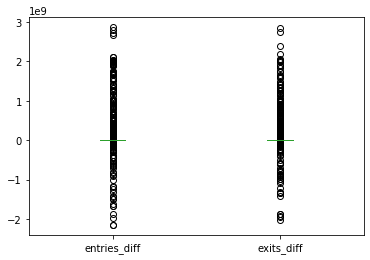

In [0]:
df[['entries_diff', 'exits_diff']].plot.box()

Parece que há muitos valores negativos, vou buscar alguns casos para entender o que está acontecendo.

In [0]:
df.query('entries_diff < 0').head()

,time,ca,unit,scp,station,linename,division,entries,exits,group_id,entries_diff,exits_diff
3542,2012-10-18 17:00:00,H038,R350,00-06-01,LIVONIA AV,L,BMT,46.0,8.0,0,-6.404770e+05,-8.355520e+05
18251,2012-07-30 21:00:00,A060,R001,00-00-07,WHITEHALL ST,R1,BMT,444.0,19.0,2,-7.906000e+03,-2.331000e+03
30108,2013-02-26 17:00:00,A037,R170,05-00-02,14 ST UNION SQ,LNRQ456,BMT,1884.0,248.0,4,-1.398129e+07,-4.689422e+06
44694,2016-05-11 21:00:00,R228,R143,00-00-01,28 ST,6,IRT,2148048.0,3755328.0,5,-1.424900e+09,-1.876058e+09
67684,2013-08-07 20:00:00,A021,R032,01-00-01,42 ST TIMES SQ,1237ACENQRS,BMT,1578335.0,1912757.0,9,-7.434389e+06,-3.430528e+06


Olhando para o `group_id = 2`, o valor acumulado zerou e assim, a difereça entre os dados de entrada ficaram negativos.

In [0]:
i = 18251
df.iloc[i-1:i+2,:]

,time,ca,unit,scp,station,linename,division,entries,exits,group_id,entries_diff,exits_diff
18250,2012-07-30 17:00:00,A060,R001,00-00-07,WHITEHALL ST,R1,BMT,8350.0,2350.0,2,296.0,170.0
18251,2012-07-30 21:00:00,A060,R001,00-00-07,WHITEHALL ST,R1,BMT,444.0,19.0,2,-7906.0,-2331.0
18252,2012-07-31 01:00:00,A060,R001,00-00-07,WHITEHALL ST,R1,BMT,1417.0,24.0,2,973.0,5.0


Já para o `group_id = 5`, parece que o contador diminui, mas não zerou. Aparentemente pode ter sido um defeito do equipamento.


In [0]:
i = 44694
df.iloc[i-1:i+2,:]

,time,ca,unit,scp,station,linename,division,entries,exits,group_id,entries_diff,exits_diff
44693,2016-05-11 17:00:00,R228,R143,00-00-01,28 ST,6,IRT,1.427048e+09,1.879814e+09,5,3.840000e+02,5.120000e+02
44694,2016-05-11 21:00:00,R228,R143,00-00-01,28 ST,6,IRT,2.148048e+06,3.755328e+06,5,-1.424900e+09,-1.876058e+09
44695,2016-05-12 01:00:00,R228,R143,00-00-01,28 ST,6,IRT,1.427049e+09,1.879814e+09,5,1.424901e+09,1.876059e+09


Dessa forma, substituirei os valores de entrada e saída negativos pelos valores acumulados.


In [0]:
df.loc[df['entries_diff'] < 0, 'entries_diff'] = df.loc[df['entries_diff'] < 0, 'entries']
df.loc[df['exits_diff'] < 0, 'exits_diff'] = df.loc[df['exits_diff'] < 0, 'exits']

No entanto, ainda há valores negativos porque os `entries` e `exits` que substituiram os `entries_diff` e `exits_diff` eram negativos.

Visto que são poucos casos, irei removê-los.

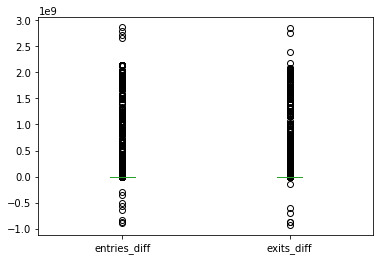

In [0]:
df[['entries_diff', 'exits_diff']].plot.box()

In [45]:
df.query('entries_diff < 0 or exits_diff < 0').shape

(15, 12)

In [0]:
df = df.query('entries_diff >= 0 and exits_diff >= 0')

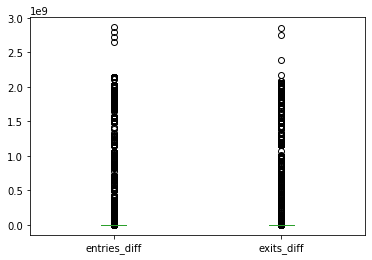

In [0]:
df[['entries_diff', 'exits_diff']].plot.box()

Agora irei tratar os outliers com valores elevados.


In [0]:
def find_outliers(df_series, multiple_IQR):
    non_zeros = df_series.replace(0, None)
    
    adjusted_IQR = (non_zeros.quantile(.75) - non_zeros.quantile(.25)) * multiple_IQR
    outlier_lim = non_zeros.quantile(.75) + adjusted_IQR
    print(f'Values above are considered outlier: {outlier_lim}')
    
    outliers = [True if x > outlier_lim else False for x in df_series]
    
    outlier_count = sum(outliers)
    all_data_count = len(df_series)
    print(f'{outlier_count} outliers identified or {round(outlier_count/all_data_count,4)*100}% of all data')
    
    sns.distplot(df_series[df_series> outlier_lim], hist=False)
    plt.show()
    
    return outliers

Uma forma comum de detectar os outliers é desconsiderar valores acima de `IQR * 1.5`, dessa forma aproximadamente teremos 94% dos dados de `entries` e 93% dos dados de `exits`.

Entries
Values above are considered outlier: 663.5
3171868 outliers identified or 6.17% of all data


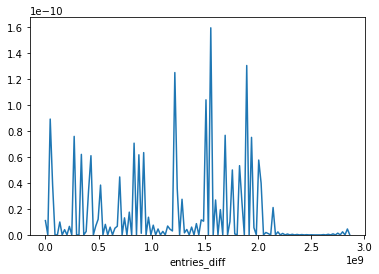


Exits
Values above are considered outlier: 468.0
3946815 outliers identified or 7.68% of all data


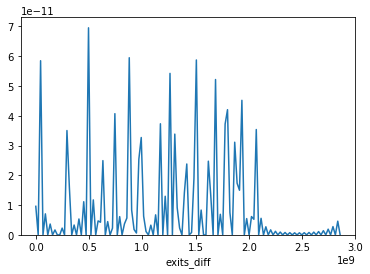

In [48]:
print('Entries')
df['entries_outlier'] = find_outliers(df['entries_diff'], 1.5)

print('\nExits')
df['exits_outlier'] = find_outliers(df['exits_diff'], 1.5)

No entando, serei mais conservador na eliminação dos dados e considerarei como outliers valores acima de `IQR * 6`.

Entries
Values above are considered outlier: 1811.0
212388 outliers identified or 0.41000000000000003% of all data


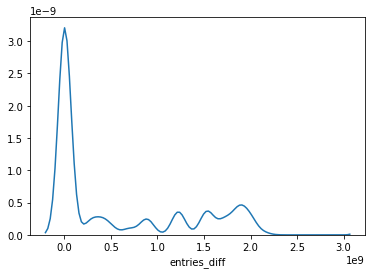


Exits
Values above are considered outlier: 1278.0
455754 outliers identified or 0.89% of all data


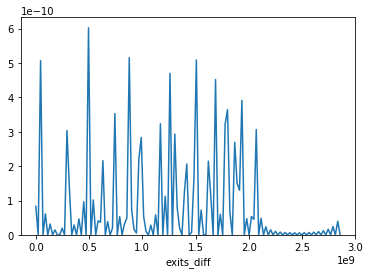

In [49]:
print('Entries')
df['entries_outlier'] = find_outliers(df['entries_diff'], 6)

print('\nExits')
df['exits_outlier'] = find_outliers(df['exits_diff'], 6)

In [0]:
def clean_df(df):
    df_clean = df.loc[(~df['entries_outlier'])&(~df['exits_outlier'])]
    num_total = len(df)
    num_outliers = len(df)-len(df_clean)
    
    df_clean = df_clean.drop(['entries', 'exits', 'entries_outlier', 'exits_outlier'], axis=1)    
    
    print(f'Total dataset: {num_total}')
    print(f'Total outliers: {num_outliers}')
    print(f'Removed {round(num_outliers/num_total, 6)} from the total dataset')
    return df_clean

In [51]:
df = clean_df(df)

Total dataset: 51399821
Total outliers: 630433
Removed 0.012265 from the total dataset


Dessa forma eliminei `630.433` outliers ou `1,2%` dos dados.

In [52]:
df.head()

,time,ca,unit,scp,station,linename,division,group_id,entries_diff,exits_diff
0,2011-01-01 05:00:00,J007,R377,00-00-02,FLUSHING AV,JM,BMT,0,392.0,117.0
1,2011-01-01 09:00:00,J007,R377,00-00-02,FLUSHING AV,JM,BMT,0,222.0,74.0
2,2011-01-01 21:00:00,J007,R377,00-00-02,FLUSHING AV,JM,BMT,0,327.0,77.0
3,2011-01-02 01:00:00,J007,R377,00-00-02,FLUSHING AV,JM,BMT,0,460.0,129.0
4,2011-01-02 05:00:00,J007,R377,00-00-02,FLUSHING AV,JM,BMT,0,196.0,93.0


In [53]:
df.shape

(50769388, 10)

O número de linhas do dataset final é de 78% em relação ao dataset original, tendo 50.769.388 linhas.

In [0]:
df.to_csv('/content/drive/My Drive/Raizen/df.csv.gz', index=False)